In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import joblib, os

sys.path.append('../')

from TS_model.vizualization import PerformEDA
from TS_model.feature_engeneering import FeatureEngineer
from TS_model.automl_tuning import ModelSelector

from TS_model.anomaly_detector import AnomalyDetector
from TS_model.breakpoints_detector import ChangeFinder

%load_ext autoreload  
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
data = pd.read_excel('../Project 2_2023.xlsx', parse_dates=True, index_col=0)
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,income,outcome,balance
0,2017-01-09,1.343028,1.487865,-0.144836
1,2017-01-10,1.068610,1.194182,-0.125572
2,2017-01-11,0.944429,0.936663,0.007767
3,2017-01-12,1.672202,0.875379,0.796823
4,2017-01-13,0.955924,0.975645,-0.019721


In [126]:
# Применение Isolation Forest для обнаружения аномалий
anomaly_detector_iforest = AnomalyDetector(contamination=0.05)
anomaly_detector_iforest.fit(data)
anomalies_iforest = anomaly_detector_iforest.detect(data)
clean_data_iforest = anomaly_detector_iforest.remove_anomalies(data)

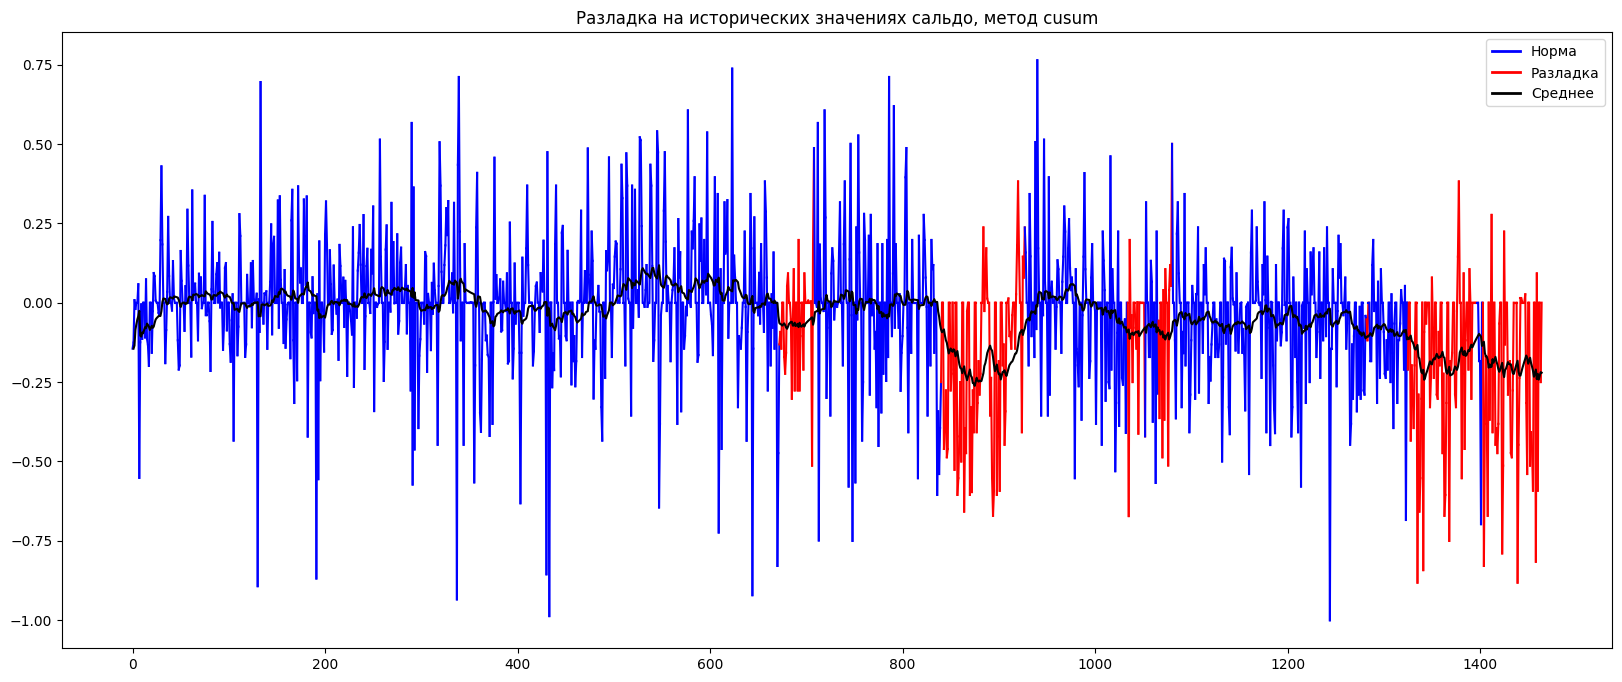

In [127]:
# Инициализация CUSUM-детектора
# параметры подобраны визуально по графику
cm = ChangeFinder(alpha=0.05, beta=0.005, method='cusum', mean_diff=-0.01, 
                              trsh=0.06, slice_length=5, breaks_max=3)
ChangeFinder.plot(clean_data_iforest,cm, method='cusum')

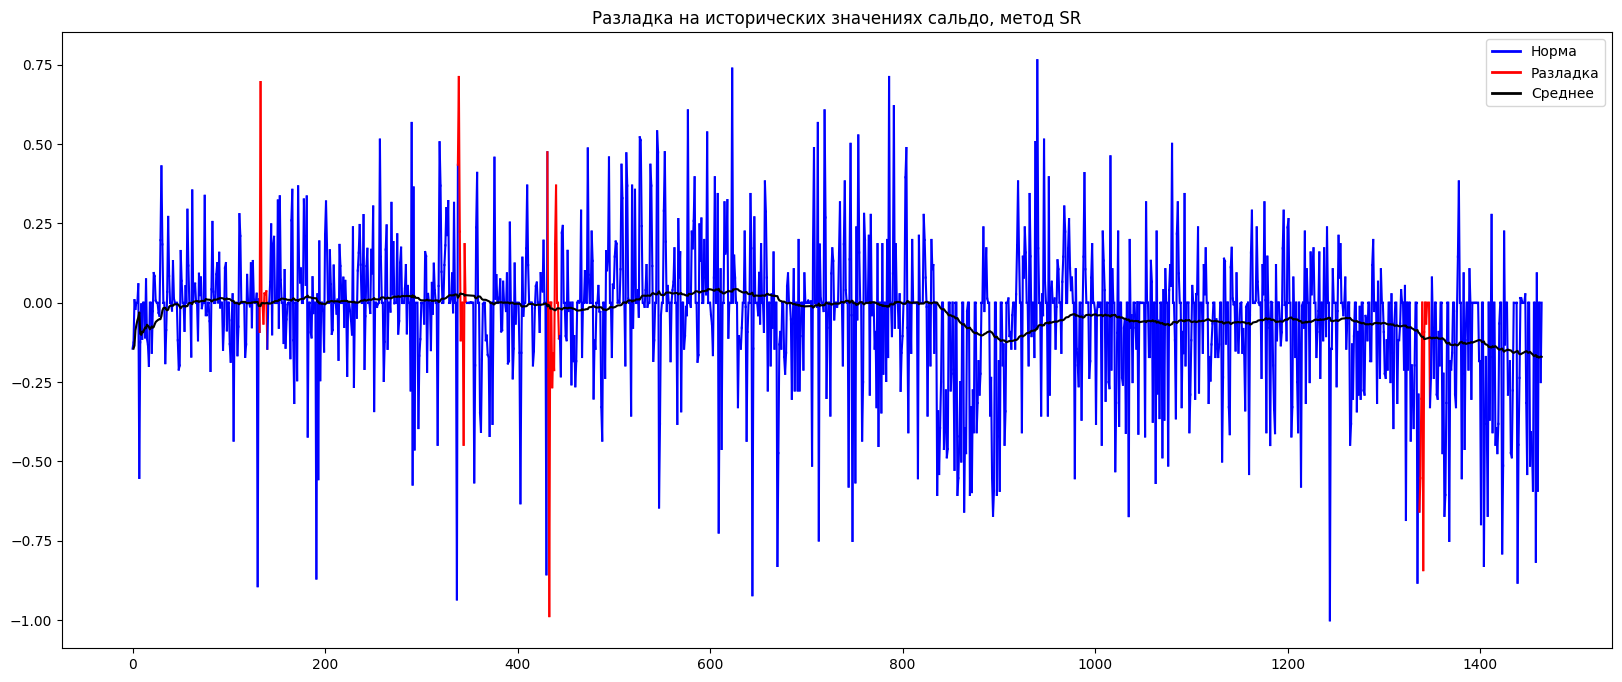

In [128]:
# Инициализация SR-детектора
# параметры подобраны визуально по графику
cr = ChangeFinder(alpha=0.01, beta=0.07, method='sr', sigma_diff = 0.5, ceil=100,
                              trsh=10, slice_length=10, breaks_max=2)
ChangeFinder.plot(clean_data_iforest,cr, method='SR')

In [129]:
# # пересчет баланса 
# data['balance'] = data['income'] - data['outcome']
# data.to_excel('../Project 2_2023.xlsx')

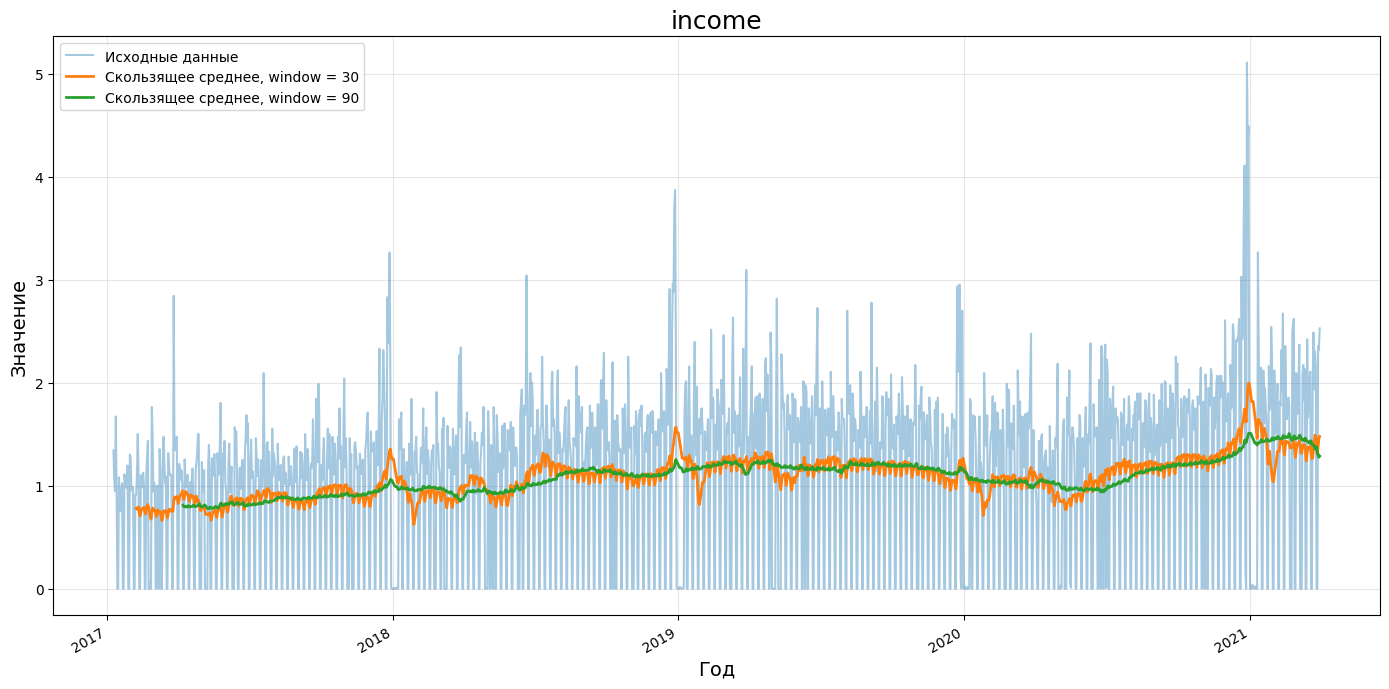

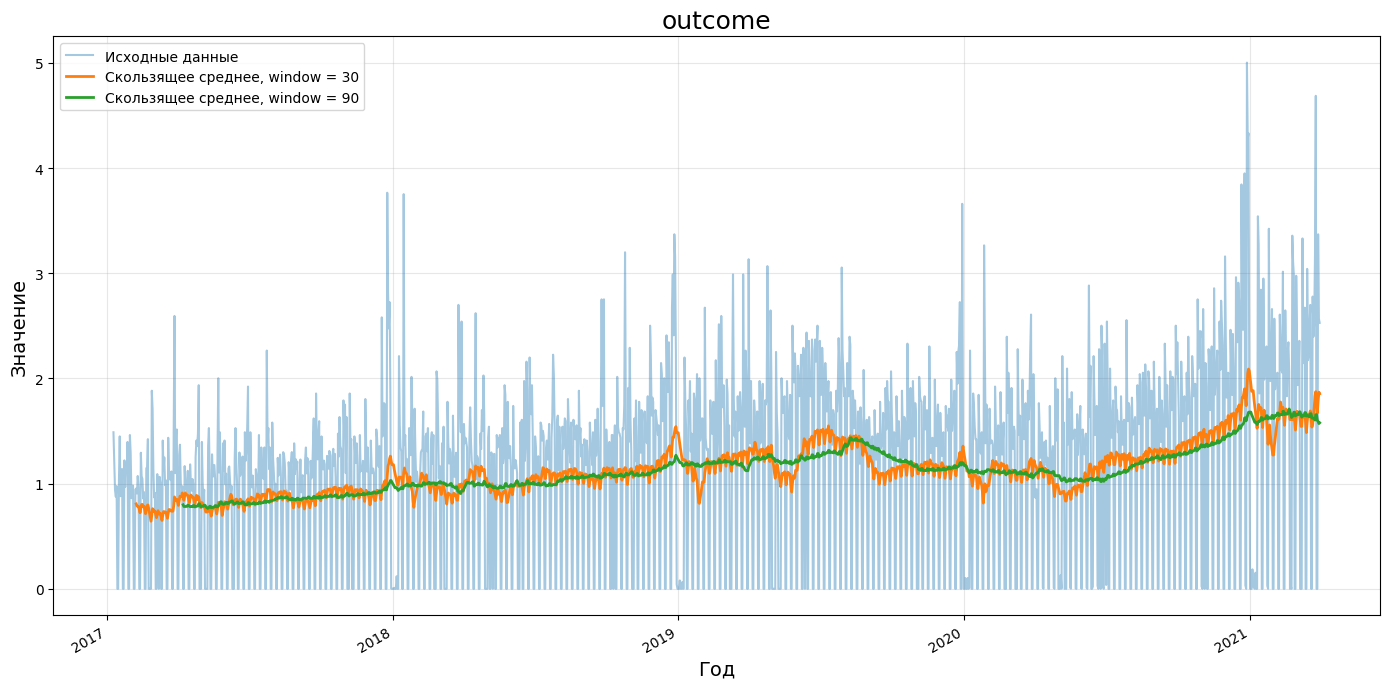

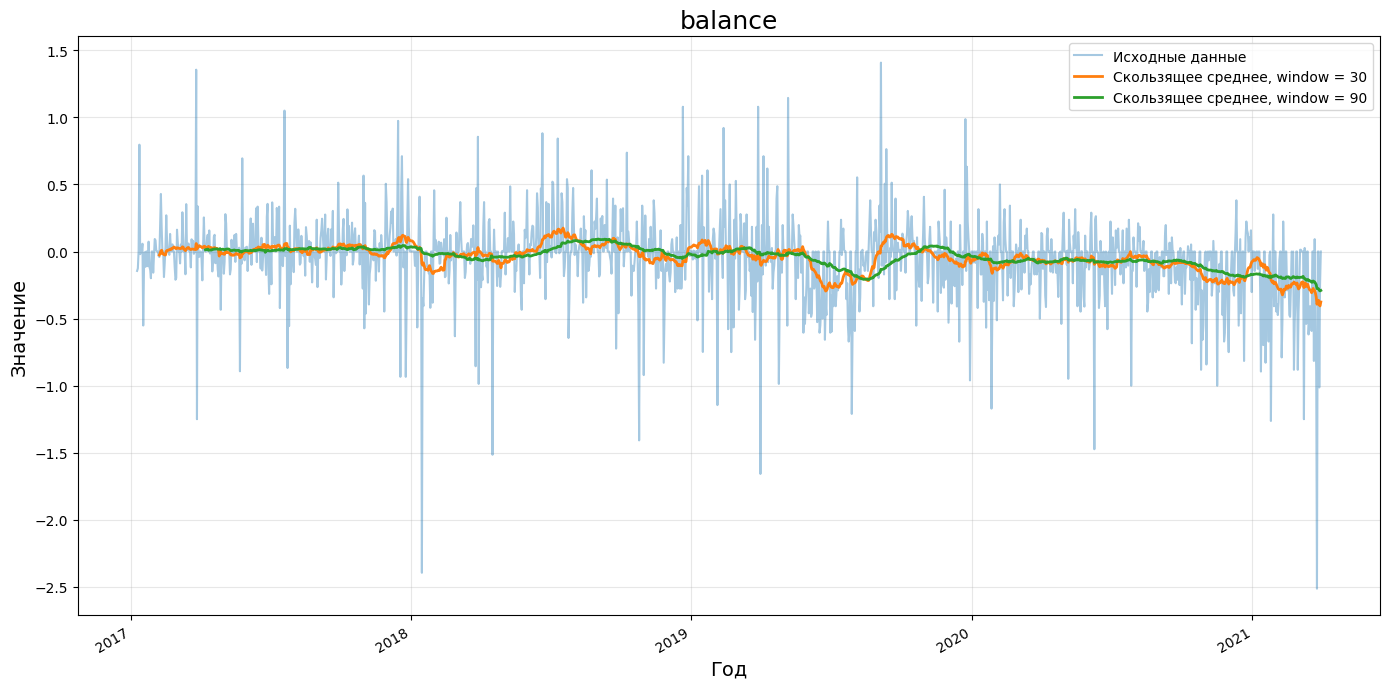

In [130]:
for col in data.copy().drop(['date'], axis=1).columns:
    PerformEDA(data=data).vizualize_var(col, windows=[30, 90])

In [131]:
feature_extactor = FeatureEngineer(data)

In [132]:
feature_extactor.add_lag_features(lags=[1, 2, 3, 7, 30, 60])
feature_extactor.add_rolling_features(windows=[3, 7, 30])
feature_extactor.add_seasonal_features()
# feature_extactor.add_special_dates() ТУТ НАДО ПЕРЕДАТЬ ДАТЫ НАЛОГОВОГО КАЛЕНДАРЯ В ФОРМАТЕ КОТОРЫЙ ЗАШИТ В МЕТОДЕ ИЛИ ПОМЕНЯТЬ МЕТОД
# add_macro_features() ДАТАФРЕЙМ МАКРО ФИЧЕЙ
x, y = feature_extactor.get_feature_df()

### Модель

In [133]:

x_train, y_train, x_test, y_test = x.iloc[0:-1], y.iloc[0:-1], x.iloc[[-1]], y.iloc[[-1]]

In [134]:
# примерные данные для показа работы модели
horizon = 10                    
x_train, y_train = x.iloc[:-horizon], y.iloc[:-horizon]
x_test,  y_test  = x.iloc[-horizon:], y.iloc[-horizon:]

In [135]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA

# ВООБЩЕ DATAPWTH ДОЛЖЕН БЫТЬ ДРУГОЙ
def fallback_model_training(model_cls=GradientBoostingRegressor, data_path='features_data.xlsx', target_col = "balance", confirm = True, **model_kwargs):
    """
    Обучает пользовательскую модель при переходе на ручное управление. Если есть model — используем ее. Иначе создаём model_cls(**model_kwargs). По умолчанию GradientBoostingRegressor
    """
    df = pd.read_excel(data_path)
    df.drop('date', inplace=True, axis=1)
    y = df[target_col]
    x = df.drop(columns=target_col)
    model = model_cls(**model_kwargs)

    print('\n ВНИМАНИЕ!  Вы собираетесь обучить пользовательскую модель:')
    print(f'Класс модели: {model.__class__.__name__}')
    print(f'x.shape = {x.shape}, y.shape = {y.shape}')
    print('-------------------------------------------------------------')

    if confirm:
        proceed = input("Нажмите <Enter>, чтобы начать обучение, или 'q' для отмены: ")
        if proceed.lower().startswith('q'):
            raise RuntimeError('Обучение пользовательской модели отменено оператором') # на случай того, если в ручном режиме хочется использовать экзотическую модель  и переписать класс

    model.fit(x, y)
    preds = model.predict(x)
    mae = mean_absolute_error(y, preds)
    print(f'✅ Пользовательская модель обучена. MAE (train) = {mae:.4f}')
    return model


In [136]:
trigger_1 = False #detect_concept_drift()   # переобучение, если concept_drift
trigger_2 = True #manual_anomalies()   # перевод в ручное управление, если аномалии

MODEL_PATH = 'model.pkl'
TODAY       = pd.Timestamp.today().tz_localize(None)
# Если первый день месяца, то переобучаем модельку
FIRST_DAY   = TODAY.day == 1

if trigger_2:
    # жёсткий отказ от AutoML → берём свою модель (МОЖНО ПРОПИСАТЬ ЛЮБУЮ, ТА ЧТО ЗДЕСЬ ЭТО ПРОСТО БАЗОВЫЙ ПРИМЕР 
    model = fallback_model_training()
    print('Используем пользовательскую модель (fallback)')

elif trigger_1 or FIRST_DAY or not os.path.exists(MODEL_PATH):
    # нужно переобучить AutoML и сохранить - time_budget(время обучения)
    x_train.insert(0, 'date', x_train.index)
    model = ModelSelector(time_budget=300 * 12, metric='mae').find_best_model(x_train, y_train, period=1)
    joblib.dump(model, MODEL_PATH)
    print('Переобучили AutoML')

else:
    # всё норм, используем уже обученный AutoML
    x_train.insert(0, 'date', x_train.index)
    model = joblib.load(MODEL_PATH)
    print('Загрузили существующую модель')


 ВНИМАНИЕ!  Вы собираетесь обучить пользовательскую модель:
Класс модели: GradientBoostingRegressor
x.shape = (1482, 39), y.shape = (1482,)
-------------------------------------------------------------
✅ Пользовательская модель обучена. MAE (train) = 0.1252
Используем пользовательскую модель (fallback)


In [137]:
if trigger_2:
    prediction = model.predict(x_test)
else:
    x_test.insert(0, 'date', x_test.index)
    prediction = model.predict(x_test)

In [138]:
abs_errors = (y_test.values - prediction).ravel().astype(float).__abs__()
print('Ошибки по каждой точке:', abs_errors.tolist())
print('Среднее MAE:', abs_errors.mean())

Ошибки по каждой точке: [0.146058855587208, 0.3426970957464526, 0.3890687226105776, 0.29648321160579316, 0.2594599997866607, 0.057843007706201086, 0.04505896199765328, 0.07606349256141243, 0.16168979414190066, 0.7821047917569686]
Среднее MAE: 0.2556527933500828
